In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

##1. File Open

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train.columns


train data dim : (15035, 21)
test data dim : (6468, 20)


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [3]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

##4. price와 상관 관계


In [ ]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(nrows=6, ncols=2)
figure.set_size_inches(12, 18)  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

# "HP" 스탯의 scatter plot
sns.scatterplot(data=train, y="price", x="bedrooms", hue="condition", ax=ax1)
sns.scatterplot(data=train, y="price", x="bathrooms", hue="condition", ax=ax2)
sns.scatterplot(data=train, y="price", x="sqft_living", hue="condition", ax=ax3)
sns.scatterplot(data=train, y="price", x="sqft_lot", hue="condition", ax=ax4)
sns.scatterplot(data=train, y="price", x="floors", hue="condition", ax=ax5)
sns.scatterplot(data=train, y="price", x="waterfront", hue="condition", ax=ax6)
sns.scatterplot(data=train, y="price", x="view", hue="condition", ax=ax7)
sns.scatterplot(data=train, y="price", x="grade", hue="condition", ax=ax8)
sns.scatterplot(data=train, y="price", x="yr_built", hue="condition", ax=ax9)
sns.scatterplot(data=train, y="price", x="yr_renovated", hue="condition", ax=ax10)
sns.scatterplot(data=train, y="price", x="zipcode", hue="condition", ax=ax11)
sns.scatterplot(data=train, y="price", x="lat", hue="condition", ax=ax12)
plt.show()

##2. 데이타 전처리 
  1) id값은 따로 저장해두고, 학습/테스트 데이타에서 삭제한다. 
  2) date는 int 형으로 변환하여, 년도/달까지만 저장한다. 
  3) price는 y값으로 따로 저장하고, 학습데이타에서 삭제한다. 

In [5]:
del train['id']

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']

print('train data columns : {}'.format(train.columns))
train.head()

train data columns : Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
test_id = test['id']
del test['id']

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

print('test data columns : {}'.format(test.columns))
test.head()

test data columns : Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [7]:
##3. 데이타 분포 확인

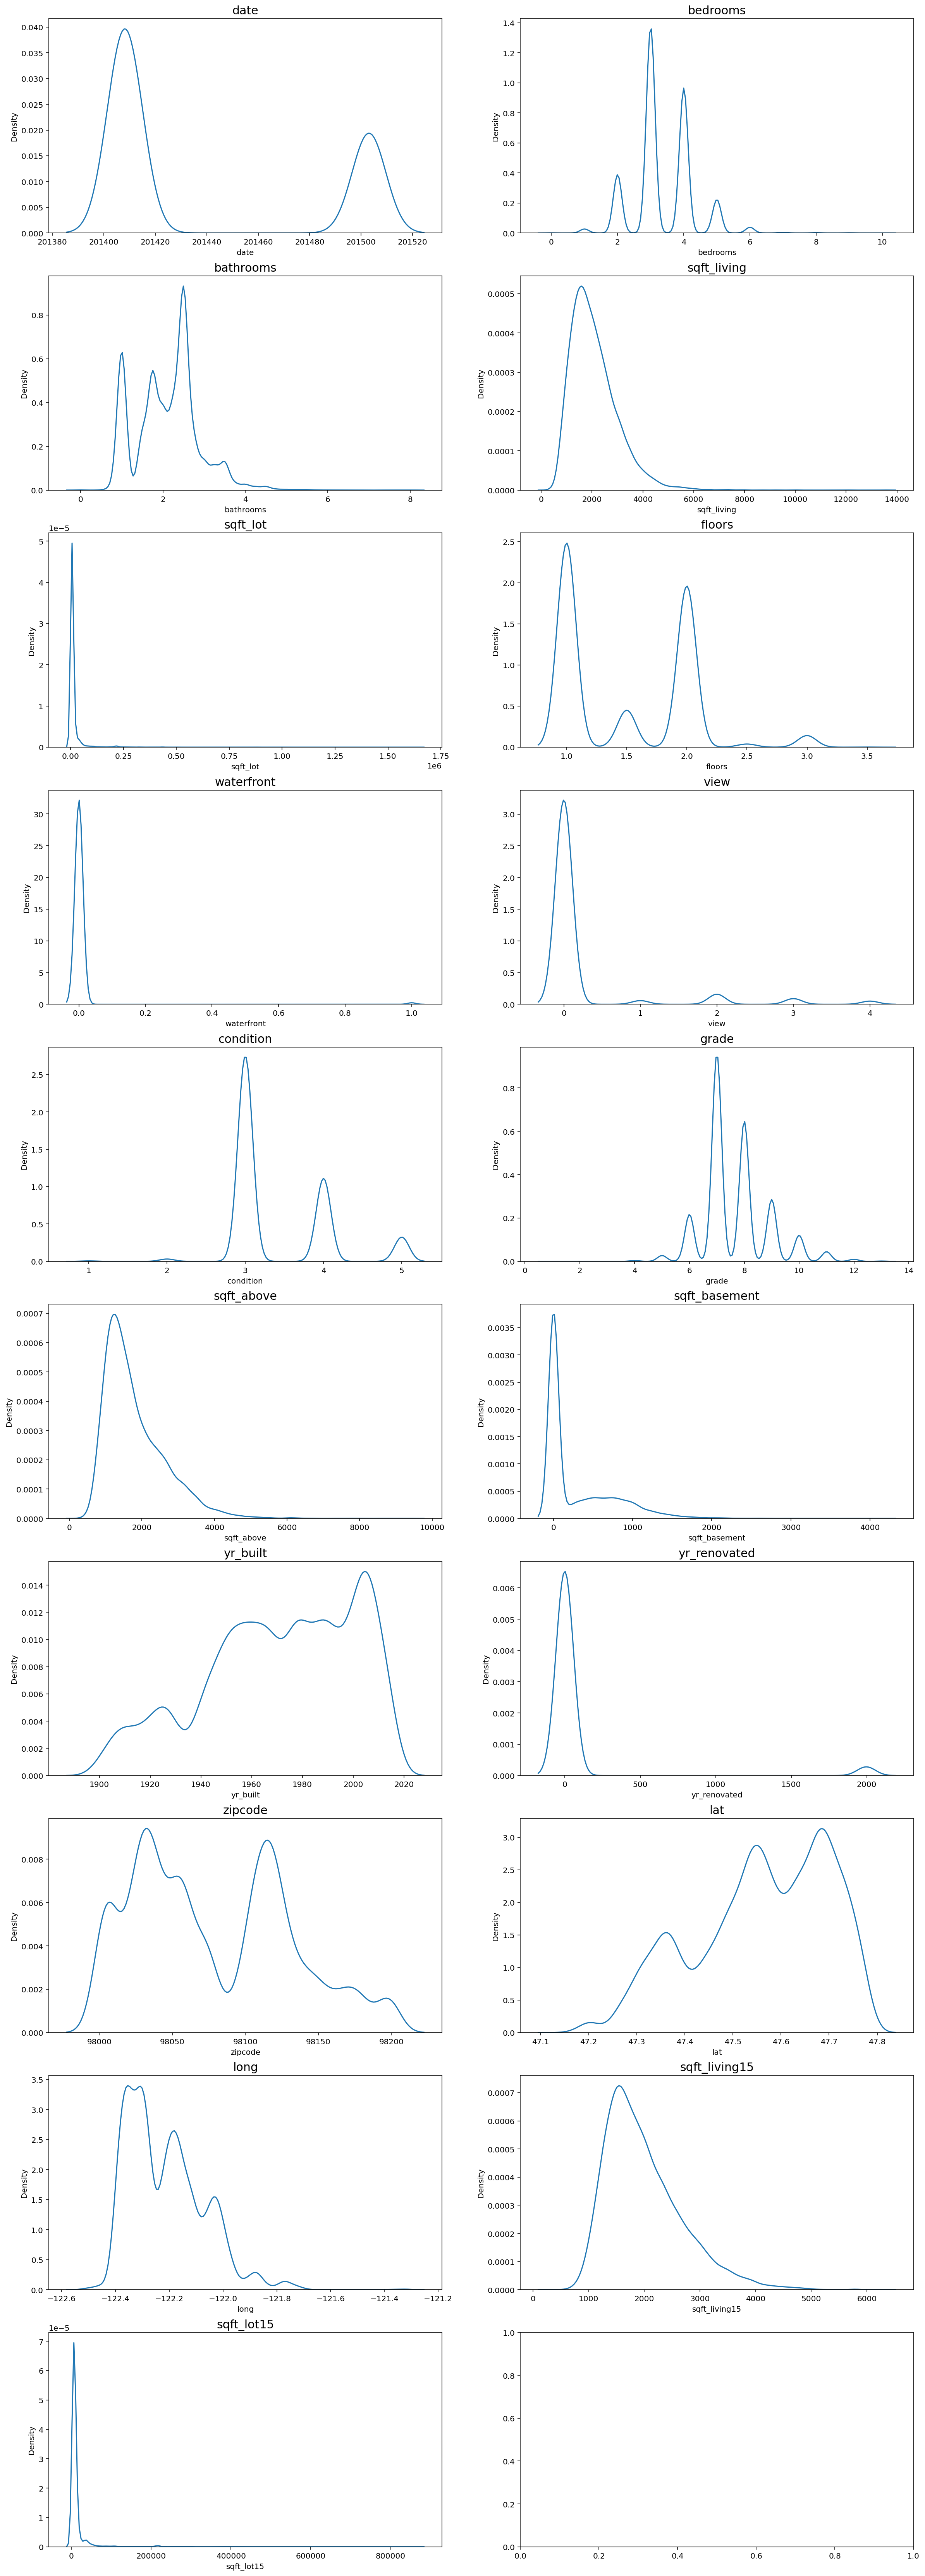

In [8]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

3. y값을 정규분포로 나타내도록 log화한다

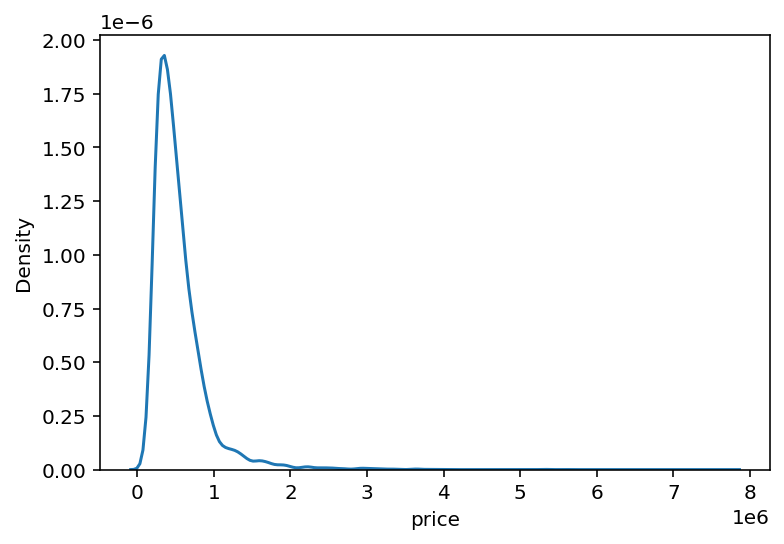

In [9]:
sns.kdeplot(y)
plt.show()

In [10]:
y = np.log1p(y.values)
y

array([12.30998662, 12.10071769, 13.14216797, ..., 12.79386209,
       12.89922233, 12.69158354])

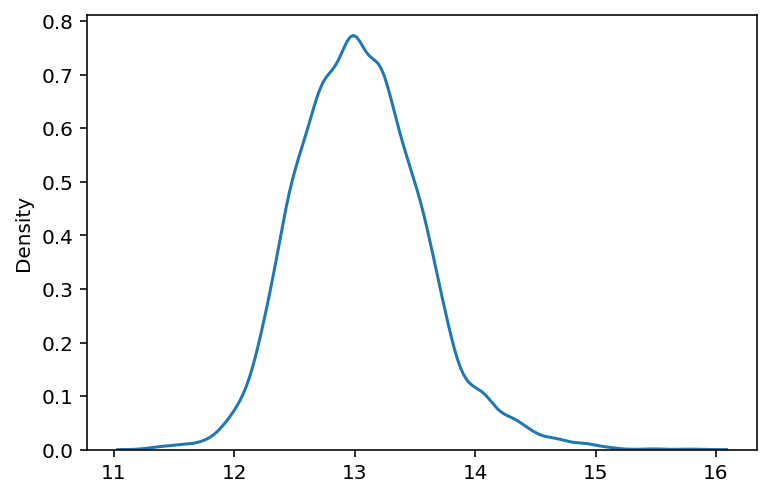

In [11]:
sns.kdeplot(y)
plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   int64  
 1   bedrooms       6468 non-null   int64  
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   int64  
 4   sqft_lot       6468 non-null   int64  
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   int64  
 11  sqft_basement  6468 non-null   int64  
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  zipcode        6468 non-null   int64  
 15  lat            6468 non-null   float64
 16  long           6468 non-null   float64
 17  sqft_living15  6468 non-null   int64  
 18  sqft_lot

In [14]:

from sklearn.metrics import mean_squared_error

# y_test, u_pred을 numpy.log1p()를 한 값이 들어올 것이므로, expm1을 해줘야 함. 
# numpy.expm1 : expotencial -1 계산

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

- LGBM, XGBM, GradientBoost, RandomForest

In [15]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020     # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


모델별 훈련하고, 예측 결과의 RMSE값을 가져오는 함수

In [16]:
from sklearn.model_selection import train_test_split

def get_scores(models, train, y):
    df = {}
    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        preditions = model.predict(X_test)
        
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse( y_test, preditions)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
     
    print('df : {}'.format(df))
    return score_df
    
get_scores(models, train, y)

df : {'GradientBoostingRegressor': 128360.19649691365, 'XGBRegressor': 110318.66956616656, 'LGBMRegressor': 111920.36735892233, 'RandomForestRegressor': 125487.07102453562}


,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566



대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.

* max_depth : 의사 결정 나무의 깊이, 정수 사용
* learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
* n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
* num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
* boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력
"""

In [17]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 
함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

from sklearn.model_selection import GridSearchCV

# 그리드 탐색 : 하이퍼 파라미터 값들을 셋탕해놓고, 그 값들로 만들어질 수 있는 모든 조합을 탐색. 
# 랜덤 탐색 : 랜덤으로 조합을 선택해서 탐색 




def my_GridSearch(model, train, y, param_grid, verbose, n_jobs) :  
    # param_grid : 탐색할 파리미터의 종류
    # scoring : 모델의 성능 평가 지표
    # cv : cross validation을 수행하기 위해 train dataset을 나누는 조각의 개수
    # verbos : 출력 메시지 양
    # n_jobs : 사용할 CPU 개수
    grid_model = GridSearchCV(model, param_grid=param_grid, 
                        scoring='neg_mean_squared_error', 
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)
    
    print('cross validation restult : {}'.format(grid_model.cv_results_))
    
           
     # 파리미터별 결과   
    results = pd.DataFrame( grid_model.cv_results_['params'] )
    
    # 각각에 대한 테스트 점수는 mean_test_score
    # 파라미터별로 score 저장
    results['score'] = grid_model.cv_results_['mean_test_score']
    
    # log로 변환한 y(price)로 계산했으므로, 실제로는 RMSLE읻. 
    # Root Mean Squared Log Error 
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results.sort_values( by='RMSLE', ascending=True)
    
    return results


param_grid = {
    'max_depth': [1, 10],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, 2, 5)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
cross validation restult : {'mean_fit_time': array([0.43923798, 0.66993589, 1.31839075, 2.2412652 , 0.42038164,
       0.64591908, 1.19944515, 1.9358613 ]), 'std_fit_time': array([0.0594669 , 0.03867491, 0.07002126, 0.0507467 , 0.01546245,
       0.0247342 , 0.06259093, 0.03481754]), 'mean_score_time': array([0.03133702, 0.05040832, 0.08664165, 0.17735238, 0.02690926,
       0.0539711 , 0.09516287, 0.10183902]), 'std_score_time': array([0.00451327, 0.00857302, 0.00574843, 0.02354114, 0.00249827,
       0.00879525, 0.01061363, 0.04707993]), 'param_learning_rate': masked_array(data=[0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[1, 1, 10, 10, 1, 1, 10, 10],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dty

,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.05,1,100,-0.074104,0.272221
1,0.05,1,200,-0.055456,0.235492
2,0.05,10,100,-0.029227,0.170960
3,0.05,10,200,-0.026848,0.163852
4,0.10,1,100,-0.055020,0.234564
5,0.10,1,200,-0.045195,0.212591
6,0.10,10,100,-0.027027,0.164399
7,0.10,10,200,-0.026188,0.161828


In [18]:
# max_depth 10, n_estimators 100이 결과가 제일 좋으므로, 이 값으로 학습
model = LGBMRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, random_state=random_state)


submission 파일에 저장

In [19]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    # y는 numpy.log1p()를 한 값이므로, expm1을 해줘야 함.
    prediction = np.expm1(prediction)
    
    
    # sample file open
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # save result file
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    
    print(submission_csv_path)
    
    

In [20]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161828')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161828.csv


In [21]:
print("==kaggle ranking : 115201.78826")

==kaggle ranking : 115201.78826
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=200; total time=   0.7s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   1.3s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=200; total time=   2.5s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   0.4s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time=   1.3s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=200; total time=   2.1s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=200; total time=   0.7s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=   1.4s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=200; total time=   2